# TensroFlow Quantum でQCL

In [157]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

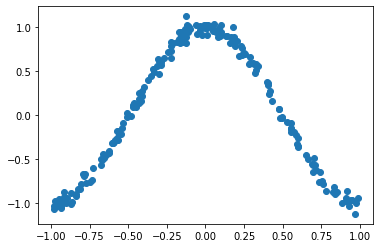

In [185]:
########  パラメータ  #############
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間

## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 200

## 学習したい1変数関数
func_to_learn = lambda x: np.cos(x*np.pi)

## 乱数のシード
random_seed = 2
## 乱数発生器の初期化
np.random.seed(random_seed)

#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

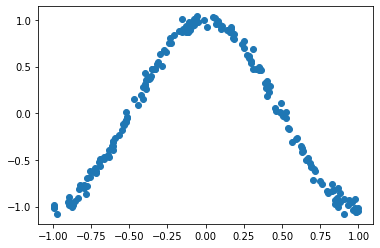

In [186]:
#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [192]:
x_test = x_train[100:]
y_test = y_train[100:]
x_train = x_train[:100]
y_train = y_train[:100]

## 入力状態の作成

In [193]:
def convert_to_circuit(x):
    """Encode truncated classical image into quantum datapoint."""
    y = np.arcsin(x)
    z = np.arccos(x**2)
    qubits = cirq.GridQubit.rect(5, 1)
    circuit = cirq.Circuit()
    for i in range(5):
        circuit.append(cirq.ry(y).on(qubits[i]))
        circuit.append(cirq.rz(z).on(qubits[i]))
    return circuit


In [194]:
x_train_circ = [convert_to_circuit(x) for x in x_train]

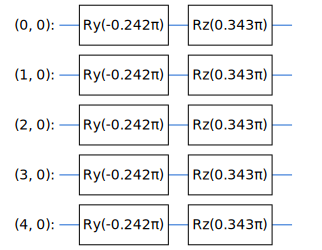

In [195]:
SVGCircuit(x_train_circ[0])

In [196]:
x_train[0],np.arcsin(x_train[0])/np.pi

(-0.6881109750779713, -0.24155978649947196)

In [197]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)

## パラメトリック量子回路（ニューラルネット）の作成

In [198]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
            
    def add_layer_single(self,circuit,gate,prefix):
        symbol = sympy.Symbol(prefix + '-' + str(0))
        circuit.append(gate(symbol).on(self.readout))
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i+1))
            circuit.append(gate(symbol).on(qubit))
    
    def add_entangler(self,circuit,len_qubit):
        circuit.append(cirq.CZ(self.readout,self.data_qubits[0]))
        for i in range(len_qubit-1):
            circuit.append(cirq.CZ(self.data_qubits[i],self.data_qubits[(i+1)%len_qubit]))
        circuit.append(cirq.CZ(self.readout,self.data_qubits[-1]))
            

In [199]:
def create_quantum_model(c_depth=3):
    data_qubits = cirq.GridQubit.rect(5,1)
    readout = cirq.GridQubit(-1,-1)
    circuit = cirq.Circuit()

    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout = readout
    )
    
    for i in range(3):
        builder.add_entangler(circuit,5)
        builder.add_layer(circuit, gate = cirq.XX, prefix='xx'+str(i))
        builder.add_layer(circuit, gate = cirq.ZZ, prefix='zz'+str(i))
        builder.add_layer(circuit, gate = cirq.XX, prefix='xx'+str(i))
    
    return circuit, cirq.Z(readout)

In [200]:
model_circuit, model_readout = create_quantum_model()

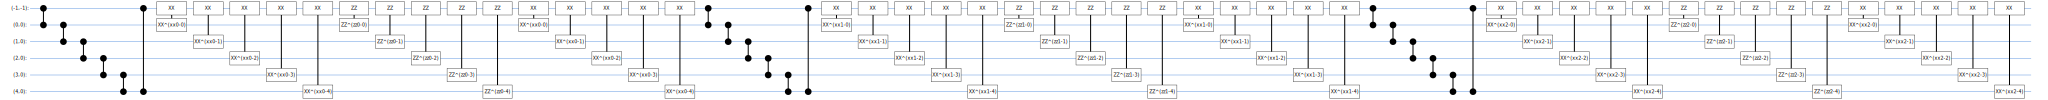

In [201]:
SVGCircuit(model_circuit)

In [202]:
model_readout

cirq.Z.on(cirq.GridQubit(-1, -1))

In [203]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [204]:
model.compile(
    loss=tf.keras.losses.mse,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae'])

In [205]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_7 (PQC)                  (None, 1)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None


In [206]:
EPOCHS = 100
BATCH_SIZE = 50

In [207]:
qnn_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=16,
      epochs=EPOCHS,
      verbose=1,
)

Train on 100 samples
Epoch 1/100
100/100 [==============================] - 2s 18ms/sample - loss: 0.5524 - mae: 0.6607
Epoch 2/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.4919 - mae: 0.6256
Epoch 3/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.4460 - mae: 0.5966
Epoch 4/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.4071 - mae: 0.5720
Epoch 5/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.3788 - mae: 0.5528
Epoch 6/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.3546 - mae: 0.5354
Epoch 7/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.3383 - mae: 0.5222
Epoch 8/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.3253 - mae: 0.5107
Epoch 9/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.3138 - mae: 0.5011
Epoch 10/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.3037 - 

100/100 [==============================] - 1s 12ms/sample - loss: 0.1006 - mae: 0.2886
Epoch 83/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.0999 - mae: 0.2878
Epoch 84/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.0993 - mae: 0.2868
Epoch 85/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.0987 - mae: 0.2858
Epoch 86/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.0982 - mae: 0.2848
Epoch 87/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.0976 - mae: 0.2840
Epoch 88/100
100/100 [==============================] - 1s 14ms/sample - loss: 0.0975 - mae: 0.2842
Epoch 89/100
100/100 [==============================] - 1s 13ms/sample - loss: 0.0969 - mae: 0.2835
Epoch 90/100
100/100 [==============================] - 1s 12ms/sample - loss: 0.0964 - mae: 0.2824
Epoch 91/100
100/100 [==============================] - 1s 13ms/sample - loss: 0.0958 - mae: 0.2809
Epoch 92/100


In [209]:
model.evaluate(x_train_tfcirc,y_train)

100/100 [==============================] - 0s 2ms/sample - loss: 0.0920 - mae: 0.2750


[0.09200199902057647, 0.2750287]